In [11]:
from utils import write_loss, get_config, Timer
from trainer import MUNIT_Trainer, UNIT_Trainer
import torch.backends.cudnn as cudnn
import torch
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import json
import numpy as np
from fid_score import calculate_frechet_distance

from my_utils import (multiple_gpu_gen, multiple_gpu_dis,
                      load_dataset, LoaderSampler, tensor2img,
                      get_Z_pushed_loader_stats, make_prediction)

In [12]:
opts_trainer = "MUNIT"
opts_output_path = "."
opts_resume = False

opts_config = "configs/handbags2shoes.yaml"
config = get_config(opts_config)
max_iter = config['max_iter']
display_size = config['display_size']
config['vgg_model_path'] = opts_output_path
batch_size = config['batch_size']

DEVICE_IDS = [4]
SEED = 0x000000

device = f'cuda:{DEVICE_IDS[0]}'

In [13]:
trainer = MUNIT_Trainer(config, device)

iteration = "00970001"
gen_name = "gen_" + iteration + ".pt"
gen_name_full = os.path.join("../checkpoints/MUNIT_nips/dtd_shoes_128", gen_name)

In [14]:
state_dict = torch.load(gen_name_full)

In [15]:
def rename_keys(state_dict):
    new_dict = {}
    for key in state_dict.keys():
        new_key = key.replace(".module", "")
        new_dict[new_key] = state_dict[key]
    
    return new_dict

new_states_dict_a = rename_keys(state_dict['a'])
new_states_dict_b = rename_keys(state_dict['b'])

trainer.gen_a.load_state_dict(new_states_dict_a)
trainer.gen_b.load_state_dict(new_states_dict_b)

trainer = trainer.to(device)

In [1]:
DATASET1, DATASET1_PATH = 'dtd', '../data/dtd/images'
DATASET2, DATASET2_PATH = 'shoes', '../data/shoes_128.hdf5'

IMG_SIZE = 128

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32)

NameError: name 'json' is not defined

In [17]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)

X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

In [9]:
FID_EPOCHS = 50
num_calculation_fid = 10
fid_values = []

for i in range(num_calculation_fid):
    mu, sigma = get_Z_pushed_loader_stats(trainer,
                                          X_test_sampler.loader,
                                          device,
                                          n_epochs=FID_EPOCHS)
    fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    print(f"FID = {fid}")
    fid_values.append(fid)
    
fid_values = np.array(fid_values)
fid_mean = np.mean(fid_values)
fid_std = np.std(fid_values)
print("--------")
print(f"Mean FID = {fid_mean}")
print(f"Std FID = {fid_std}")

FID = 43.63416047696131
FID = 43.9042298986877
FID = 43.43022146635673
FID = 43.78446068557358
FID = 43.73595930701367
FID = 43.60381005056436
FID = 43.6916317737269
FID = 43.97517634136511
FID = 43.952157913090645
FID = 43.71097345006166
--------
Mean FID = 43.742278136340175
Std FID = 0.16066300281711193


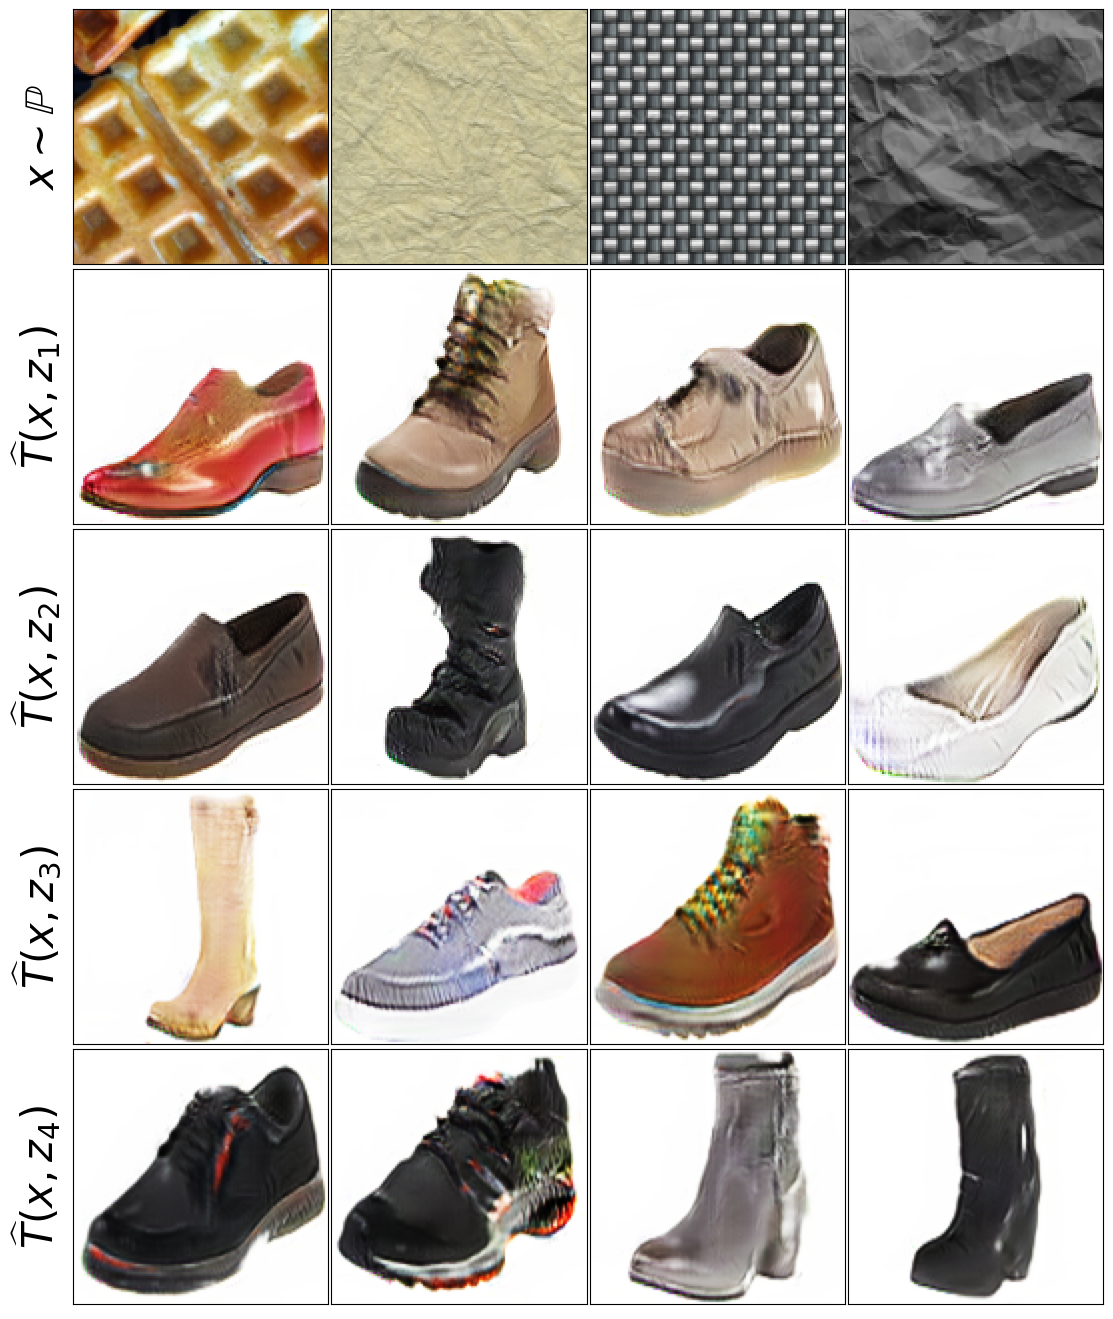

In [19]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_test_fixed_variable = Variable(X_test_fixed).to(device)

num_examples = 4
Y_test_fakes = []

for v in range(num_examples):
    prior_z_B_current = Variable(torch.randn(X_test_fixed_variable.size(0), trainer.style_dim, 1, 1)).to(device)

    fake_Y_test = make_prediction(X_test_fixed_variable, prior_z_B_current, trainer).detach()
    fake_Y_test_numpy = tensor2img(fake_Y_test)
    Y_test_fakes.append(fake_Y_test_numpy)

real_X_test_numpy = tensor2img(X_test_fixed)
real_Y_test_numpy = tensor2img(Y_test_fixed)

fig, axes = plt.subplots(5, 4, figsize=(11, 13), dpi=100)
X_tensor = real_X_test_numpy
Y_tensor = real_Y_test_numpy
Y_fake_tensor = Y_test_fakes

for j in range(4):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    #axes[0][j].get_yaxis().set_visible(False)

for i in range(4):
    for j in range(4):
        cur_img = Y_fake_tensor[i][j]

        axes[i + 1][j].imshow(cur_img)
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])
        #axes[i + 1][j].get_yaxis().set_visible(False)
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1, 0].set_ylabel(r'${}$'.format(title), fontsize=30)
    
fig.tight_layout(pad=0.001)    
plt.savefig("munit_textures2shoes_test.png")0